# Gradient Descent from Scratch

A complete implementation of gradient descent optimization — built from first principles using only NumPy.

**What's covered:**
1. Numerical differentiation & tangent lines
2. Gradient computation (arbitrary dimensions)
3. Gradient descent with multiple learning rate schedules
4. Multi-start strategy for global optimization
5. Momentum-based gradient descent
6. Stochastic Gradient Descent (SGD)
7. Linear regression as an optimization problem

## 1. Setup & Styling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

# Global plot style
plt.rcParams.update({
    "figure.figsize": (9, 5),
    "figure.dpi": 120,
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.3,
    "font.size": 11,
    "lines.linewidth": 2
})

COLORS = ["#2196F3", "#FF5722", "#4CAF50", "#9C27B0", "#FF9800"]
np.random.seed(42)

## 2. Numerical Differentiation

The derivative of $f$ at point $a$ is approximated by the **finite difference** method:

$$f'(a) \approx \frac{f(a + \varepsilon) - f(a)}{\varepsilon}$$

We use this to compute tangent lines: the tangent to $f$ at point $a$ is the linear function $T_a(x) = f'(a)(x - a) + f(a)$.

In [2]:
def numerical_derivative(f, a, eps=1e-7):
    """Approximate derivative of f at point a using forward finite differences."""
    return (f(a + eps) - f(a)) / eps


def tangent_line(f, a, x, eps=1e-7):
    """Compute the tangent line to f at point a, evaluated at x."""
    slope = numerical_derivative(f, a, eps)
    return slope * (x - a) + f(a)

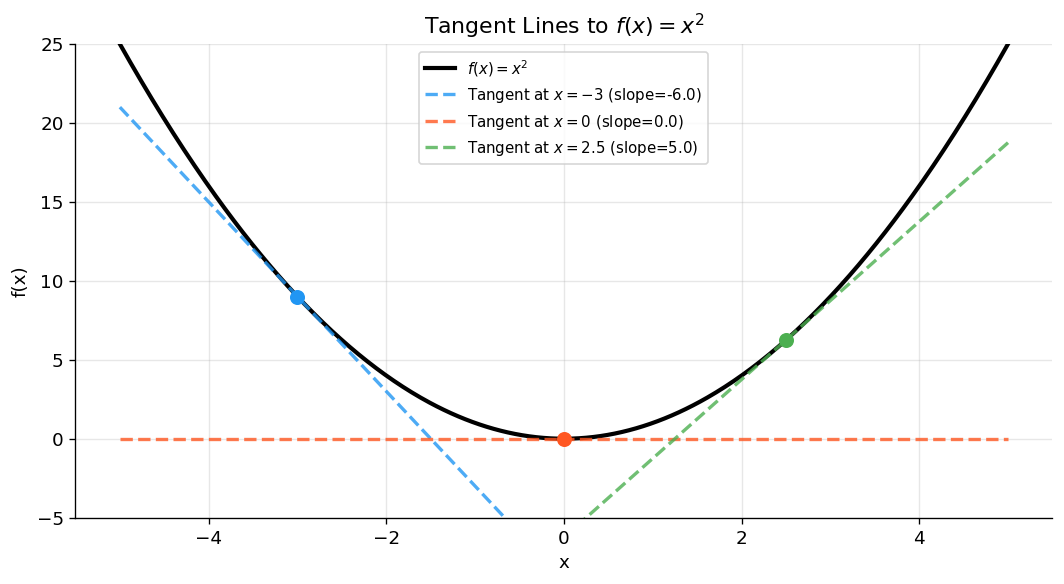

In [3]:
f = lambda x: x**2
x = np.linspace(-5, 5, 500)
touch_points = [-3, 0, 2.5]

fig, ax = plt.subplots()
ax.plot(x, f(x), color="black", linewidth=2.5, label="$f(x) = x^2$")

for i, a in enumerate(touch_points):
    y_tan = tangent_line(f, a, x)
    slope = numerical_derivative(f, a)
    ax.plot(x, y_tan, "--", color=COLORS[i], alpha=0.8,
            label=f"Tangent at $x={a}$ (slope={slope:.1f})")
    ax.plot(a, f(a), "o", color=COLORS[i], markersize=8, zorder=5)

ax.set_ylim(-5, 25)
ax.set(xlabel="x", ylabel="f(x)", title="Tangent Lines to $f(x) = x^2$")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 3. Gradient Computation

For a multivariate function $f: \mathbb{R}^n \to \mathbb{R}$, the **gradient** is the vector of partial derivatives:

$$\nabla f(\mathbf{a}) = \begin{pmatrix} \frac{\partial f}{\partial x_1}(\mathbf{a}) \\ \vdots \\ \frac{\partial f}{\partial x_n}(\mathbf{a}) \end{pmatrix}$$

Each partial derivative is approximated numerically by perturbing one dimension at a time.

In [4]:
def compute_gradient(f, a, eps=1e-7):
    """Compute the gradient of f at point a using forward finite differences."""
    n = len(a)
    grad = np.zeros(n)
    f_a = f(a)
    for i in range(n):
        a_shifted = a.copy()
        a_shifted[i] += eps
        grad[i] = (f(a_shifted) - f_a) / eps
    return grad


# --- Verification against the analytical gradient of the Rosenbrock function ---

def rosenbrock(a):
    x, y = a[0], a[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_grad_analytical(a):
    x, y = a[0], a[1]
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

test_point = np.array([1.0, 2.0])
numerical = compute_gradient(rosenbrock, test_point)
analytical = rosenbrock_grad_analytical(test_point)

print("Gradient verification at (1, 2):")
print(f"  Numerical:  {numerical}")
print(f"  Analytical: {analytical}")
print(f"  Max error:  {np.max(np.abs(numerical - analytical)):.2e}")

Gradient verification at (1, 2):
  Numerical:  [-399.99998009  200.00000973]
  Analytical: [-400.  200.]
  Max error:  1.99e-05


## 4. Gradient Descent

The update rule is simple: move in the direction opposite to the gradient, scaled by a learning rate $\alpha$:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \, \nabla f(\mathbf{x}_k)$$

We support four **learning rate schedules**:

| Schedule | Formula |
|---|---|
| Constant | $\alpha_k = \alpha_0$ |
| Linear decay | $\alpha_k = \alpha_0 / (k+1)$ |
| Quadratic decay | $\alpha_k = \alpha_0 / (k+1)^2$ |
| Exponential decay | $\alpha_k = \alpha_0 \, e^{-0.05k}$ |

In [5]:
def gradient_descent(f, intervals, x0=None, lr=0.1, schedule="constant",
                     max_iter=500, tol=1e-6, eps=1e-7, clip_to_bounds=True):
    """
    Gradient descent optimizer.

    Parameters
    ----------
    f : callable            - Objective function f(x) -> float
    intervals : array-like  - Search bounds [[lo, hi], ...] per dimension
    x0 : array-like         - Starting point (random if None)
    lr : float              - Initial learning rate
    schedule : str          - 'constant', 'linear', 'quadratic', or 'exponential'
    max_iter : int          - Maximum iterations
    tol : float             - Stop when ||grad|| < tol
    clip_to_bounds : bool   - Project back into bounds after each step

    Returns
    -------
    result : dict with keys 'x', 'f', 'converged', 'n_iter', 'history'
    """
    intervals = np.asarray(intervals, dtype=float)

    if x0 is None:
        x = np.array([np.random.uniform(lo, hi) for lo, hi in intervals])
    else:
        x = np.asarray(x0, dtype=float)

    history = {"x": [], "f": [], "grad_norm": [], "lr": []}

    for k in range(max_iter):
        grad = compute_gradient(f, x, eps)
        grad_norm = np.linalg.norm(grad)

        history["x"].append(x.copy())
        history["f"].append(f(x))
        history["grad_norm"].append(grad_norm)

        if grad_norm < tol:
            for key in history:
                history[key] = np.array(history[key])
            return {"x": x, "f": f(x), "converged": True,
                    "n_iter": k + 1, "history": history}

        # Learning rate schedule
        if schedule == "linear":
            alpha = lr / (k + 1)
        elif schedule == "quadratic":
            alpha = lr / (k + 1) ** 2
        elif schedule == "exponential":
            alpha = lr * np.exp(-0.05 * k)
        else:
            alpha = lr

        history["lr"].append(alpha)
        x = x - alpha * grad

        if clip_to_bounds:
            x = np.clip(x, intervals[:, 0], intervals[:, 1])

    for key in history:
        history[key] = np.array(history[key])
    return {"x": x, "f": f(x), "converged": False,
            "n_iter": max_iter, "history": history}


def multistart_gd(f, intervals, n_starts=10, **kwargs):
    """Run gradient descent from multiple random starting points, return the best."""
    best = None
    for _ in range(n_starts):
        result = gradient_descent(f, intervals, **kwargs)
        if best is None or result["f"] < best["f"]:
            best = result
    return best

### 4.1 — 1D Example: $f(x) = x^2$

Converged: True  |  Iterations: 20
Solution:  x = 0.00000017  |  f(x) = 2.89e-14


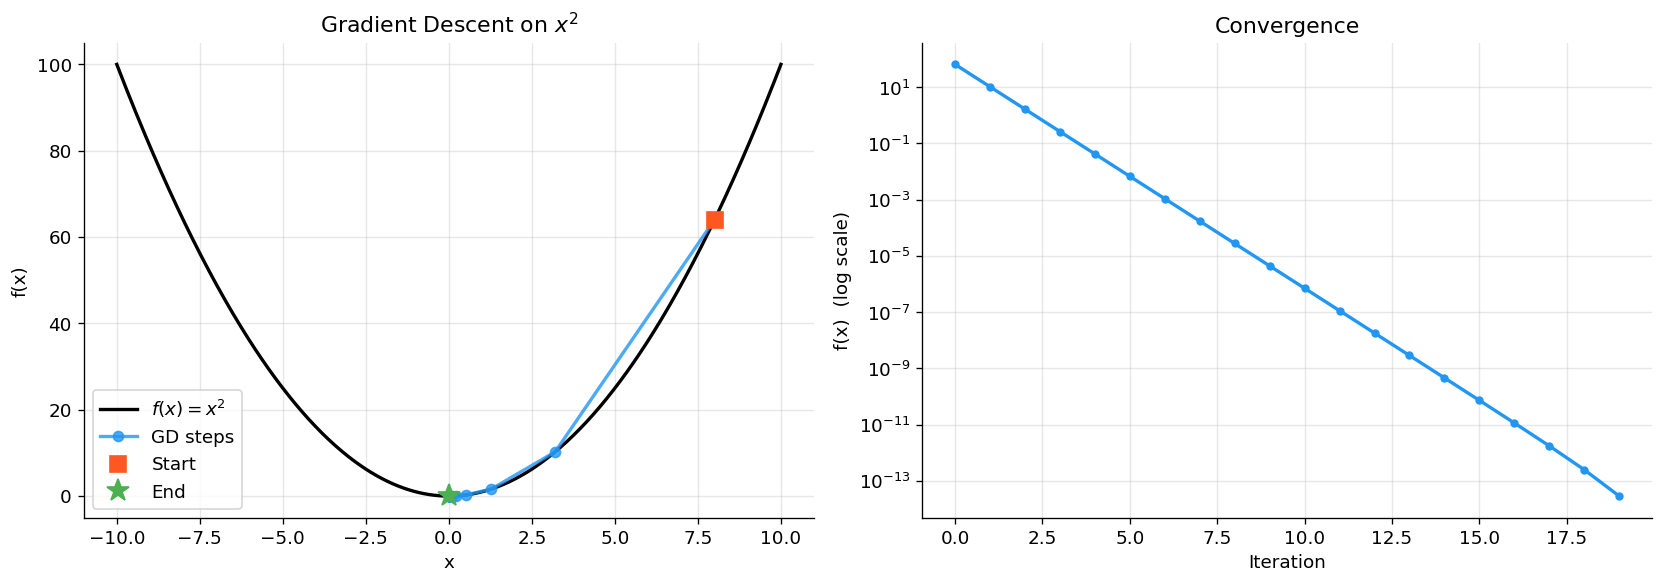

In [6]:
quadratic = lambda a: a[0] ** 2
intervals_1d = np.array([[-10.0, 10.0]])

result = gradient_descent(quadratic, intervals_1d, x0=np.array([8.0]),
                          lr=0.3, max_iter=25)

print(f"Converged: {result['converged']}  |  Iterations: {result['n_iter']}")
print(f"Solution:  x = {result['x'][0]:.8f}  |  f(x) = {result['f']:.2e}")

# --- Plot the descent path ---
x_vals = np.linspace(-10, 10, 500)
hist_x = result["history"]["x"][:, 0]
hist_f = result["history"]["f"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: function + path
ax1.plot(x_vals, x_vals**2, color="black", linewidth=2, label="$f(x) = x^2$")
ax1.plot(hist_x, hist_f, "o-", color=COLORS[0], markersize=6, alpha=0.8,
         label="GD steps")
ax1.plot(hist_x[0], hist_f[0], "s", color=COLORS[1], markersize=10, zorder=5,
         label="Start")
ax1.plot(hist_x[-1], hist_f[-1], "*", color=COLORS[2], markersize=14, zorder=5,
         label="End")
ax1.set(xlabel="x", ylabel="f(x)", title="Gradient Descent on $x^2$")
ax1.legend()

# Right: convergence
ax2.semilogy(result["history"]["f"], "o-", color=COLORS[0], markersize=4)
ax2.set(xlabel="Iteration", ylabel="f(x)  (log scale)",
        title="Convergence")
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### 4.2 — Learning Rate Schedule Comparison

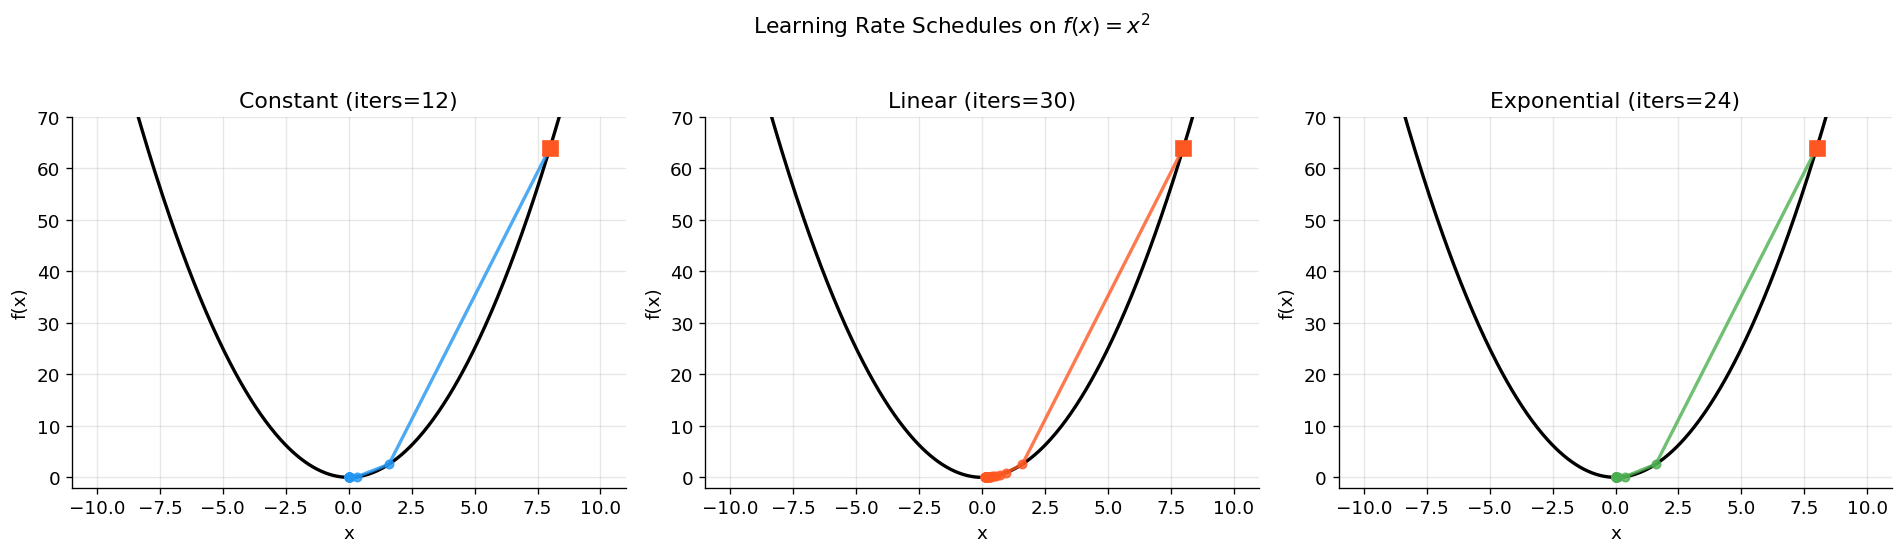

In [7]:
schedules = ["constant", "linear", "exponential"]
x0 = np.array([8.0])

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

for i, sched in enumerate(schedules):
    res = gradient_descent(quadratic, intervals_1d, x0=x0, lr=0.4,
                           schedule=sched, max_iter=30)

    ax = axes[i]
    ax.plot(x_vals, x_vals**2, color="black", linewidth=2)

    hx = res["history"]["x"][:, 0]
    hf = res["history"]["f"]
    ax.plot(hx, hf, "o-", color=COLORS[i], markersize=5, alpha=0.8)
    ax.plot(hx[0], hf[0], "s", color=COLORS[1], markersize=9, zorder=5)
    ax.set(xlabel="x", ylabel="f(x)",
           title=f"{sched.capitalize()} (iters={res['n_iter']})")
    ax.set_ylim(-2, 70)

plt.suptitle("Learning Rate Schedules on $f(x) = x^2$", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### 4.3 — 2D Example: Rosenbrock Function

The Rosenbrock function is a classic benchmark for optimization:

$$f(x, y) = (1 - x)^2 + 100(y - x^2)^2$$

The global minimum is at $(1, 1)$ where $f = 0$, but the narrow curved valley makes it notoriously hard to optimize.

Converged: False  |  Iterations: 5000
Solution:  [0.91405767 0.83513944]  |  f(x) = 0.007399


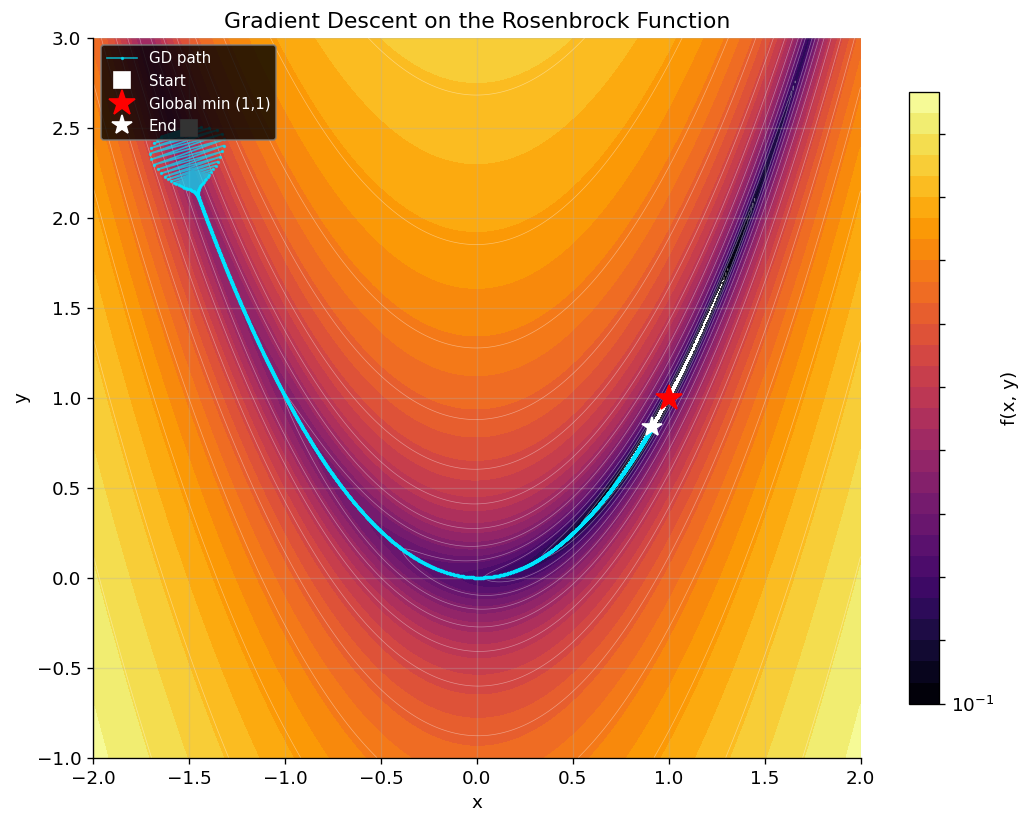

In [8]:
intervals_2d = np.array([[-2.0, 2.0], [-1.0, 3.0]])

result_2d = gradient_descent(rosenbrock, intervals_2d, x0=np.array([-1.5, 2.5]),
                             lr=0.001, schedule="constant", max_iter=5000)

print(f"Converged: {result_2d['converged']}  |  Iterations: {result_2d['n_iter']}")
print(f"Solution:  {result_2d['x']}  |  f(x) = {result_2d['f']:.6f}")

# --- Contour plot ---
xg = np.linspace(-2, 2, 400)
yg = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(xg, yg)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

fig, ax = plt.subplots(figsize=(9, 7))
contour = ax.contourf(X, Y, Z, levels=np.logspace(-1, 3.5, 30), cmap="inferno",
                       norm=LogNorm())
ax.contour(X, Y, Z, levels=np.logspace(-1, 3.5, 15), colors="white",
           linewidths=0.4, alpha=0.4)

# Optimization path
path = np.array(result_2d["history"]["x"])
ax.plot(path[:, 0], path[:, 1], ".-", color="#00E5FF", linewidth=1, markersize=2,
        alpha=0.7, label="GD path")
ax.plot(path[0, 0], path[0, 1], "ws", markersize=10, zorder=5, label="Start")
ax.plot(1, 1, "r*", markersize=16, zorder=5, label="Global min (1,1)")
ax.plot(path[-1, 0], path[-1, 1], "w*", markersize=12, zorder=5, label="End")

ax.set(xlabel="x", ylabel="y", title="Gradient Descent on the Rosenbrock Function")
ax.legend(loc="upper left", fontsize=9, facecolor="black", labelcolor="white",
          edgecolor="gray")
plt.colorbar(contour, ax=ax, label="f(x, y)", shrink=0.85)
plt.tight_layout()
plt.show()

## 5. Momentum-Based Gradient Descent

Standard GD can oscillate in narrow valleys. **Momentum** fixes this by accumulating a velocity vector:

$$\mathbf{v}_{k+1} = \beta \, \mathbf{v}_k + \nabla f(\mathbf{x}_k) \qquad \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha \, \mathbf{v}_{k+1}$$

The parameter $\beta \in [0, 1)$ controls how much past gradients influence the current step.

In [9]:
def gradient_descent_momentum(f, intervals, x0=None, lr=0.001, beta=0.9,
                               max_iter=5000, tol=1e-6, eps=1e-7,
                               clip_to_bounds=True):
    """Gradient descent with momentum."""
    intervals = np.asarray(intervals, dtype=float)
    n = len(intervals)

    if x0 is None:
        x = np.array([np.random.uniform(lo, hi) for lo, hi in intervals])
    else:
        x = np.asarray(x0, dtype=float)

    velocity = np.zeros(n)
    history = {"x": [], "f": [], "grad_norm": []}

    for k in range(max_iter):
        grad = compute_gradient(f, x, eps)
        grad_norm = np.linalg.norm(grad)

        history["x"].append(x.copy())
        history["f"].append(f(x))
        history["grad_norm"].append(grad_norm)

        if grad_norm < tol:
            for key in history:
                history[key] = np.array(history[key])
            return {"x": x, "f": f(x), "converged": True,
                    "n_iter": k + 1, "history": history}

        velocity = beta * velocity + grad
        x = x - lr * velocity

        if clip_to_bounds:
            x = np.clip(x, intervals[:, 0], intervals[:, 1])

    for key in history:
        history[key] = np.array(history[key])
    return {"x": x, "f": f(x), "converged": False,
            "n_iter": max_iter, "history": history}

### Vanilla GD vs Momentum on Rosenbrock

Method       Converged    Iters    f(x*)          x*
----------------------------------------------------------------------
Vanilla      False        5000     0.007399       [0.91405767 0.83513944]
Momentum     False        5000     0.000122       [0.98896221 0.97800185]


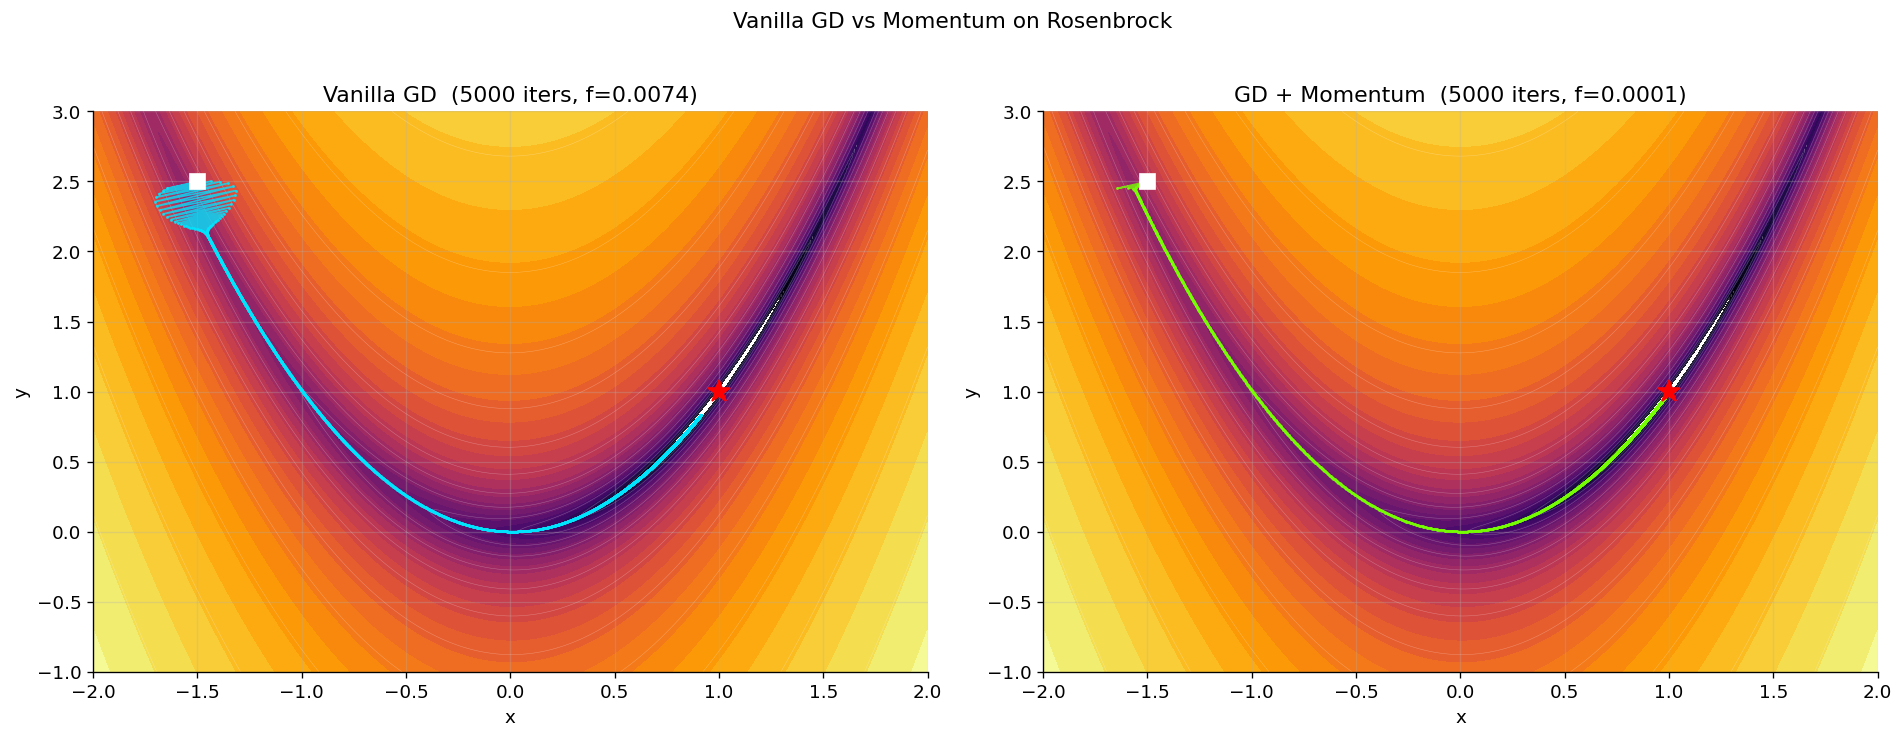

In [10]:
x0 = np.array([-1.5, 2.5])

res_vanilla = gradient_descent(rosenbrock, intervals_2d, x0=x0,
                               lr=0.001, max_iter=5000)
res_momentum = gradient_descent_momentum(rosenbrock, intervals_2d, x0=x0,
                                          lr=0.001, beta=0.5, max_iter=5000)

print(f"{'Method':<12} {'Converged':<12} {'Iters':<8} {'f(x*)':<14} {'x*'}")
print("-" * 70)
for name, r in [("Vanilla", res_vanilla), ("Momentum", res_momentum)]:
    print(f"{name:<12} {str(r['converged']):<12} {r['n_iter']:<8} "
          f"{r['f']:<14.6f} {r['x']}")

# --- Side by side contour comparison ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (name, res, color) in zip(axes, [
    ("Vanilla GD", res_vanilla, "#00E5FF"),
    ("GD + Momentum", res_momentum, "#76FF03"),
]):
    ax.contourf(X, Y, Z, levels=np.logspace(-1, 3.5, 30), cmap="inferno",
                norm=LogNorm())
    ax.contour(X, Y, Z, levels=np.logspace(-1, 3.5, 15), colors="white",
               linewidths=0.3, alpha=0.3)

    path = res["history"]["x"]
    ax.plot(path[:, 0], path[:, 1], ".-", color=color, linewidth=1,
            markersize=1.5, alpha=0.8)
    ax.plot(path[0, 0], path[0, 1], "ws", markersize=9)
    ax.plot(1, 1, "r*", markersize=14)
    ax.set(xlabel="x", ylabel="y",
           title=f"{name}  ({res['n_iter']} iters, f={res['f']:.4f})")

plt.suptitle("Vanilla GD vs Momentum on Rosenbrock", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### Convergence Comparison

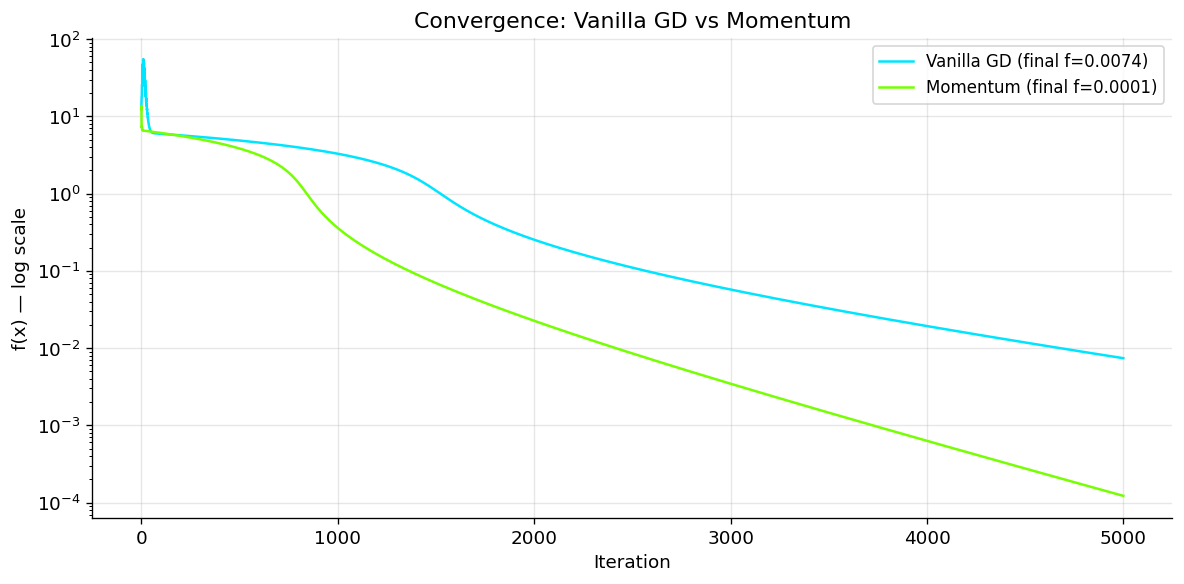

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(res_vanilla["history"]["f"], color="#00E5FF", linewidth=1.5,
            label=f"Vanilla GD (final f={res_vanilla['f']:.4f})")
ax.semilogy(res_momentum["history"]["f"], color="#76FF03", linewidth=1.5,
            label=f"Momentum (final f={res_momentum['f']:.4f})")
ax.set(xlabel="Iteration", ylabel="f(x) — log scale",
       title="Convergence: Vanilla GD vs Momentum")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

## 6. Stochastic Gradient Descent (SGD)

In machine learning, the loss function is typically a **sum over data points**:

$$L(\theta) = \frac{1}{n}\sum_{i=1}^{n} \ell_i(\theta)$$

Instead of computing the full gradient at every step (expensive), **SGD** approximates it using random mini-batches:

$$\nabla L(\theta) \approx \frac{1}{|B|}\sum_{i \in B} \nabla \ell_i(\theta)$$

This introduces noise but enables much faster convergence on large datasets.

In [12]:
def sgd(loss_fn, theta0, X, y, lr=0.01, batch_size=16,
        epochs=50, eps=1e-7):
    """
    Mini-batch Stochastic Gradient Descent.

    Parameters
    ----------
    loss_fn : callable   - loss(theta, X_batch, y_batch) -> float
    theta0 : array       - Initial parameters
    X, y : arrays        - Dataset
    lr : float           - Learning rate
    batch_size : int     - Mini-batch size
    epochs : int         - Number of passes over the dataset

    Returns
    -------
    result : dict with 'theta', 'history'
    """
    theta = np.asarray(theta0, dtype=float)
    n = len(X)
    history = {"loss": [], "theta": []}

    for epoch in range(epochs):
        indices = np.random.permutation(n)

        for start in range(0, n, batch_size):
            batch_idx = indices[start:start + batch_size]
            X_b, y_b = X[batch_idx], y[batch_idx]

            def batch_loss(t):
                return loss_fn(t, X_b, y_b)

            grad = compute_gradient(batch_loss, theta, eps)
            theta = theta - lr * grad

        history["loss"].append(loss_fn(theta, X, y))
        history["theta"].append(theta.copy())

    for key in history:
        history[key] = np.array(history[key])
    return {"theta": theta, "history": history}

## 7. Application — Linear Regression

We fit a line $\hat{y} = ax + b$ by minimizing the **Mean Squared Error**:

$$\text{MSE}(a, b) = \frac{1}{n}\sum_{i=1}^{n}(y_i - ax_i - b)^2$$

We solve this three ways: full-batch GD, multi-start GD, and SGD.

In [13]:
# --- Generate noisy linear data ---
np.random.seed(42)
a_true, b_true = 2.5, 4.0
sigma = 2.0
n_points = 80

X_data = np.linspace(0, 10, n_points)
y_data = a_true * X_data + b_true + np.random.normal(0, sigma, n_points)

# --- Loss functions ---
def mse_loss(theta, X, y):
    a, b = theta
    return np.mean((y - a * X - b) ** 2)

def mse_full(theta):
    """Full-batch MSE (for use with gradient_descent)."""
    return mse_loss(theta, X_data, y_data)

# --- Method 1: Full-batch gradient descent ---
intervals_reg = np.array([[0.0, 5.0], [0.0, 10.0]])
res_gd = gradient_descent(mse_full, intervals_reg, lr=0.005,
                          max_iter=1000, clip_to_bounds=False)

# --- Method 2: Multi-start gradient descent ---
res_ms = multistart_gd(mse_full, intervals_reg, n_starts=10, lr=0.005,
                       max_iter=1000, clip_to_bounds=False)

# --- Method 3: SGD ---
res_sgd = sgd(mse_loss, theta0=np.array([0.0, 0.0]), X=X_data, y=y_data,
              lr=0.003, batch_size=16, epochs=100)

print(f"{'Method':<16} {'a':>8} {'b':>8} {'MSE':>10}")
print("-" * 44)
for name, theta in [("Full-batch GD", res_gd["x"]),
                     ("Multi-start GD", res_ms["x"]),
                     ("SGD", res_sgd["theta"])]:
    print(f"{name:<16} {theta[0]:8.4f} {theta[1]:8.4f} "
          f"{mse_loss(theta, X_data, y_data):10.4f}")
print(f"{'True values':<16} {a_true:8.4f} {b_true:8.4f}")

Method                  a        b        MSE
--------------------------------------------
Full-batch GD      2.5367   3.5392     3.6218
Multi-start GD     2.5090   3.7239     3.6193
SGD                2.7531   2.1444     4.2040
True values        2.5000   4.0000


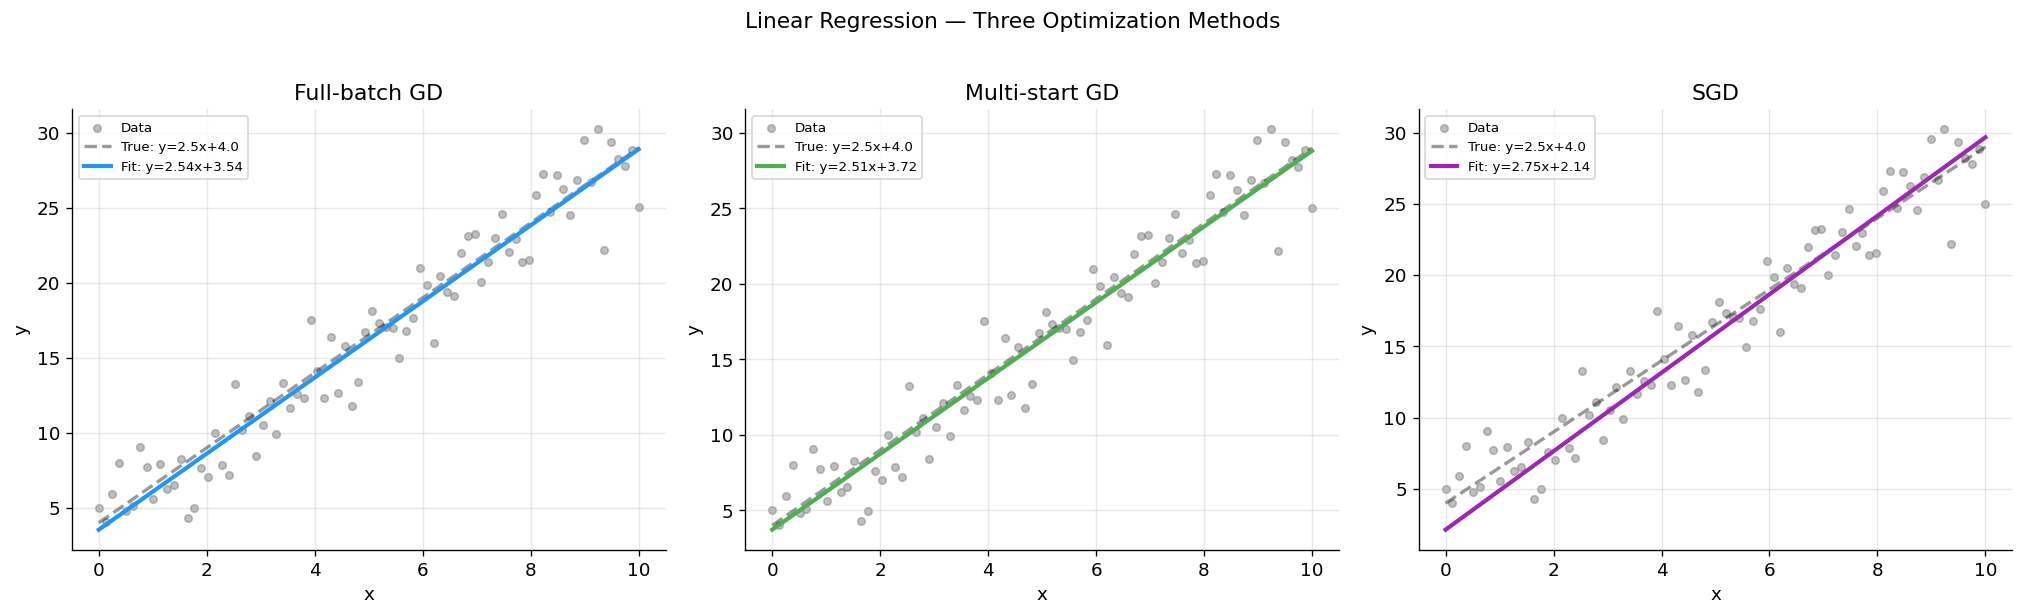

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
x_line = np.linspace(0, 10, 100)

methods = [
    ("Full-batch GD", res_gd["x"], COLORS[0]),
    ("Multi-start GD", res_ms["x"], COLORS[2]),
    ("SGD", res_sgd["theta"], COLORS[3]),
]

for ax, (name, theta, color) in zip(axes, methods):
    ax.scatter(X_data, y_data, s=20, alpha=0.5, color="gray", label="Data")
    ax.plot(x_line, a_true * x_line + b_true, "--", color="black",
            alpha=0.4, label=f"True: y={a_true}x+{b_true}")
    ax.plot(x_line, theta[0] * x_line + theta[1], color=color, linewidth=2.5,
            label=f"Fit: y={theta[0]:.2f}x+{theta[1]:.2f}")
    ax.set(xlabel="x", ylabel="y", title=name)
    ax.legend(fontsize=8)

plt.suptitle("Linear Regression — Three Optimization Methods", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### Training Curves

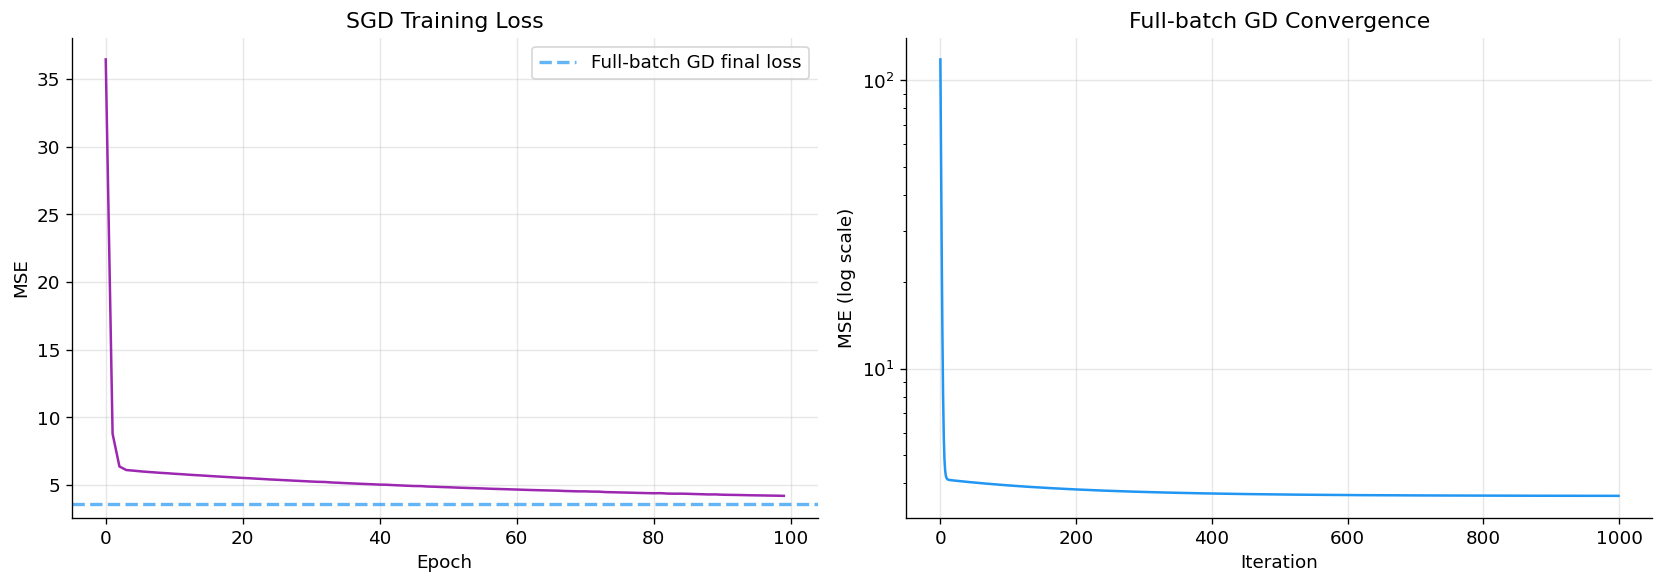

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# SGD loss curve
ax1.plot(res_sgd["history"]["loss"], color=COLORS[3], linewidth=1.5)
ax1.set(xlabel="Epoch", ylabel="MSE", title="SGD Training Loss")
ax1.axhline(mse_loss(res_gd["x"], X_data, y_data), color=COLORS[0],
            linestyle="--", alpha=0.7, label="Full-batch GD final loss")
ax1.legend()

# Full-batch GD loss curve
ax2.semilogy(res_gd["history"]["f"], color=COLORS[0], linewidth=1.5)
ax2.set(xlabel="Iteration", ylabel="MSE (log scale)",
        title="Full-batch GD Convergence")

plt.tight_layout()
plt.show()